### Setup

In [5]:
import math
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
sys.path.insert(1, os.getcwd().replace('preprocessing','')) # allows config import from one level above
import config as cfg

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [6]:
scrape_date = '2020-09-24' # date of scraped data, also used for saving respective combined and preprocessed dfs
y_back = 20 # reverse time for average calculation of past fights history (only relevant for XGBoost Input)
next_date = 'Dec. 12, 2020' # next fight night date 

### Combine Matches, Fighters, Profiles and Planned Fights in 1  DF

In [7]:
m = pd.read_csv(f"{cfg.path_data_output}{scrape_date}_Matches_List.csv")
f = pd.read_csv(f"{cfg.path_data_output}{scrape_date}_Fighters_List.csv")
p = pd.read_csv(f"{cfg.path_data_output}{scrape_date}_Profiles_List.csv")
n = pd.read_csv(f"{cfg.path_data_output}{scrape_date}_Plan_List.csv")
try:
    f.drop('Unnamed: 0',axis=1,inplace=True)
    p.drop('Unnamed: 0',axis=1,inplace=True)
except: pass

In [9]:
m.MID.value_counts().value_counts()

2    7741
1      79
Name: MID, dtype: int64

In [8]:
assert len(m.MID.value_counts().value_counts()) == 1 # every match has been scraped twice, error not crucial if something goes wrong just means some data is missing
m.MID.value_counts().value_counts()

AssertionError: 

In [7]:
# # ATTENTION MANUAL CORRECTION OF NAMES REQUIRED DUE TO MISTAKES ON UFC STATS PAGE -> Has been corrected by UFC

# def fanual_correct(first_old,first_new, second):
#     f.loc[(f.First == first_old)&(f.Last == second),'First'] = first_new


# fanual_correct('Rogerio','Minotauro','Nogueira')

# def manual_correct(name_old,name_new):
#     m.loc[m.Fighter_1 == name_old,'Fighter_1'] = name_new
#     m.loc[m.Fighter_2 == name_old,'Fighter_2'] = name_new
#     n.loc[n.Fighter_1 == name_old,'Fighter_1'] = name_new
#     n.loc[n.Fighter_2 == name_old,'Fighter_2'] = name_new
    

# manual_correct('Ronaldo Souza','Jacare Souza')
# manual_correct('Rafael Cavalcante','Rafael Feijao')
# manual_correct('Michael Chandler','Mike Chandler')
# manual_correct('Mirko Filipovic','Mirko Cro Cop')
# manual_correct('Quinton Jackson','Rampage Jackson')
# manual_correct('Cristiane Justino','Cris Cyborg')
# manual_correct('Antonio Rodrigo Nogueira','Minotauro Nogueira')
# manual_correct('Rogerio Nogueira','Minotauro Nogueira')
# manual_correct('Antonio Rogerio Nogueira','Minotauro Nogueira')
# manual_correct('Antonio Rodrigo Nogueira','Minotauro Nogueira')

In [10]:
# only QS
# f[f.Last.str.startswith('T')].shape#.iloc[-15:]
# for le in list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
#     f[f.Last.str.startswith(le)].iloc[0:3]

In [10]:
n = n[n.duplicated(['Fighter_1'],keep=False)] # delete fights if only one fighter was scraped, e.g., new fighter
n = n.sort_values('Fighter_1') # TODO: check why not keep FID -> better keep

In [11]:
n = n[n.Fighter_1 != 'Error']
n = n.reset_index(drop = True)

In [12]:
n['MID'] = ['next_' + f'{i + (i+1)%2:03d}' for i in n.index]
n['Date'] = next_date

In [13]:
r = pd.merge(m,n, how = 'outer')

In [14]:
r = pd.merge(r, f, on = 'FID') 

In [15]:
r = pd.merge(r, p.loc[:,['DOB','FID']]) # only add DOB

In [16]:
assert m.MID.value_counts().sum() == m.shape[0] # QS

In [17]:
assert r.shape[0] == m.shape[0]+n.shape[0] # QS

In [18]:
assert r[r.MID.str.startswith('next')].shape[0] == n.shape[0] # QS

In [24]:
r.loc[(r.Fighter_1 == 'Robbie Lawler') |(r.Fighter_2 == 'Robbie Lawler')].drop_duplicates('MID').shape


(34, 69)

### Preprocess DF for  Duplicates, Dataformats etc.

In [25]:
r.insert(2, 'Result', r['Result_F1'].replace({'W': 1, 'L': 0, 'NC':0.5,'D':0.5}), allow_duplicates=True) 

In [26]:
liste = list(r.columns[-11:])+['FID']

In [27]:
for column in liste:
    r[column+'_F1'] = ''
for column in liste:
    r[column+'_F2'] = ''

In [28]:
for col in liste:
    r[col+'_F1'] = [r[col][i] if r.Fighter_1[i] == str(r.First[i]) + ' ' +str(r.Last[i]) else None for i in r.index]
    r[col+'_F2'] = [r[col][i] if r.Fighter_2[i] == str(r.First[i]) + ' ' +str(r.Last[i]) else None for i in r.index]

In [29]:
# CHECK FOR INVALID NAMES HERE
r.FID_F2.isna().sum()
assert r[(r.FID_F2.isna())&(r.FID_F1.isna())].loc[:,['Fighter_1','Fighter_2','First','Last','Nick']].shape[0] == 0
assert r[(r.FID_F2.isna())&(r.FID_F1.isna())].shape[0] == 0

7801

In [30]:
r.sort_values('MID',inplace = True)
r.set_index('MID',inplace=True)
r.drop_duplicates(inplace = True)
r.reset_index(inplace=True)

In [31]:
s1 = r.drop_duplicates('MID',keep='first').set_index('MID')
s2 = r.drop_duplicates('MID',keep='last').set_index('MID')

In [32]:
r.MID.value_counts().value_counts()

2    7770
1      79
Name: MID, dtype: int64

In [33]:
r = s1.combine_first(s2) # TODO: maybe throw away fighter were only one match side was available

In [34]:
r.sort_values('MID',inplace = True)

In [35]:
del s1
del s2

In [36]:
r.drop(['FID','First','Last','Nick','HT','WT','Reach','Stance','W','L','D','DOB'],axis = 1, inplace = True)

In [37]:
r.Date = pd.to_datetime(r.Date, infer_datetime_format=True)

In [38]:
r.loc[r.DOB_F1 == '--','DOB_F1'] = None
r.loc[r.DOB_F2 == '--','DOB_F2'] = None

In [39]:
r['DOB_F1'] = pd.to_datetime(r.DOB_F1, infer_datetime_format=True)
r['DOB_F2'] = pd.to_datetime(r.DOB_F2, infer_datetime_format=True)

In [40]:
r['HT_cm_F1'] = [(int(r.HT_F1.loc[i].split("'")[0])*12+int(r.HT_F1.loc[i].split("'")[1].replace('"','').replace(' ','')))*2.54 if r.HT_F1.loc[i] != '--' and r.HT_F1.loc[i] == r.HT_F1.loc[i] and r.HT_F1.loc[i] != None else '' for i in r.index]
r['HT_cm_F2'] = [(int(r.HT_F2.loc[i].split("'")[0])*12+int(r.HT_F2.loc[i].split("'")[1].replace('"','').replace(' ','')))*2.54 if r.HT_F2.loc[i] != '--' and r.HT_F2.loc[i] == r.HT_F2.loc[i] and r.HT_F2.loc[i] != None else '' for i in r.index]

In [41]:
r['Reach_cm_F1'] = [float(r.Reach_F1.loc[i].replace('"',''))*2.54 if r.Reach_F1.loc[i] != '--' and r.Reach_F1.loc[i] == r.Reach_F1.loc[i] and r.Reach_F1.loc[i] != None else '' for i in r.index]
r['Reach_cm_F2'] = [float(r.Reach_F2.loc[i].replace('"',''))*2.54 if r.Reach_F2.loc[i] != '--' and r.Reach_F2.loc[i] == r.Reach_F2.loc[i] and r.Reach_F2.loc[i] != None else '' for i in r.index]

In [42]:
r['WT_lbs_F1'] = [int(i.split(' ')[0]) if type(i) == str and i != '--' else None for i in r.WT_F1]
r['WT_lbs_F2'] = [int(i.split(' ')[0]) if type(i) == str and i != '--' else None for i in r.WT_F2]

In [43]:
r.to_csv(f"{cfg.path_data_output}{scrape_date}_Combined.csv")

### Balance Wins vs. Losses

In [44]:
r = pd.read_csv(f"{cfg.path_data_output}{scrape_date}_Combined.csv",index_col = 0)

In [45]:
r.Date = pd.to_datetime(r.Date, infer_datetime_format=True)
r['DOB_F1'] = pd.to_datetime(r.DOB_F1, infer_datetime_format=True)
r['DOB_F2'] = pd.to_datetime(r.DOB_F2, infer_datetime_format=True)

In [46]:
assert r.index.shape[0] == r.index.nunique()

In [47]:
r.Result_F1.value_counts(dropna=False)[np.ix_(r.Result_F1.value_counts(dropna=False).index.isna())[0][0]]

np.ix_(r.Result_F1.value_counts(dropna=False).index.isna())[0][0]
r.Result_F1.value_counts(dropna=False).index

29

4

Index(['W', 'L', 'NC', 'D', nan], dtype='object')

In [48]:
s = int(r.Result_F1.value_counts()['W']-round((r.shape[0]-r.Result_F1.value_counts()['NC']-r.Result_F1.value_counts()['D']\
                                              -r.Result_F1.value_counts(dropna=False)[np.ix_(r.Result_F1.value_counts(dropna=False).index.isna())[0][0]])/2))
sample = r[r.Result_F1 == 'W'].sample(s,random_state=42)
rest = r.drop(sample.index,axis=0)

In [49]:
s
r.Result_F1.value_counts(dropna = False)

1826

W      5668
L      2016
NC       75
D        61
NaN      29
Name: Result_F1, dtype: int64

In [50]:
a = list(sample.loc[:,'Fighter_1':].columns)
b = [i[:-1]+str(int(i[-1:])*-1+3) for i in a]

In [51]:
dictionary = dict(zip(a, b))

In [52]:
sample = sample.rename(columns=dictionary)

In [53]:
sample.Result_F1 = 'L'
sample.Result = 0

In [54]:
frames = [rest,sample]
r = pd.concat(frames,sort=False)

In [55]:
r.sample()[['Result','Fighter_1','Fighter_2','FID_F1','FID_F2','DOB_F1','DOB_F2']]

,Result,Fighter_1,Fighter_2,FID_F1,FID_F2,DOB_F1,DOB_F2
MID,,,,,,,
98e21492b6bc15d3,1.0,Rafael Natal,Chris Camozzi,2254.0,441.0,1982-12-25,1986-11-20


In [56]:
r.to_csv(f"{cfg.path_data_output}{scrape_date}_balanced.csv") 

In [64]:
r.shape
r.sample(3)
r.Method.value_counts()
r.index.nunique()
r.loc[(r.Fighter_1 == 'Israel Adesanya')|(r.Fighter_2 == 'Israel Adesanya')].sort_values('Date')

(7849, 87)

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ae2dfd555dd3d55b,1.0,W,WEC 30: McCullough vs. Crunkilton,2007-09-05,U-DEC,5.0,5:00,WEC BANTAMWEIGHT TITLE BOUT,5 Rnd (5-5-5-5-5),Steve Mazzagatti,Cecil Peoples 49 - 46. Chris Lee 49 - 45. Abe ...,Chase Beebe,Rani Yahya,0.0,0.0,43.0,65.0,9.0,18.0,168.0,206.0,16.0,25.0,0.0,0.0,1.0,6.0,4.0,5.0,7.0,3.0,1.0,1.0,31.0,53.0,2.0,11.0,11.0,11.0,0.0,0.0,1.0,1.0,7.0,7.0,6.0,13.0,9.0,18.0,0.0,0.0,0.0,0.0,37.0,52.0,0.0,0.0,Chase,Beebe,NaN,"5' 7""",135 lbs.,"67.0""",Orthodox,24.0,13.0,1.0,1985-03-29,232.0,Rani,Yahya,NaN,"5' 6""",135 lbs.,"67.0""",Orthodox,26.0,10.0,1.0,1984-09-12,3485.0,170.18,167.64,170.18,170.18,135.0,135.0
fd776d7b554a85d0,0.0,L,UFC 188: Velasquez vs Werdum,2015-06-13,S-DEC,3.0,5:00,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),John McCarthy,Sal D'amato 28 - 29. Chris Lee 29 - 28. Derek ...,Gilbert Melendez,Eddie Alvarez,0.0,0.0,37.0,129.0,31.0,64.0,93.0,187.0,43.0,79.0,0.0,1.0,3.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,119.0,16.0,47.0,4.0,10.0,8.0,10.0,0.0,0.0,7.0,7.0,36.0,123.0,29.0,61.0,1.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,Gilbert,Melendez,El Nino,"5' 9""",145 lbs.,"73.0""",Orthodox,22.0,8.0,0.0,1982-04-12,2055.0,Eddie,Alvarez,NaN,"5' 9""",155 lbs.,"69.0""",Orthodox,29.0,6.0,0.0,1984-01-11,78.0,175.26,175.26,185.42,175.26,145.0,155.0
a501d75e238496c5,0.0,L,PRIDE Final Conflict 2003,2003-11-09,SUB,3.0,2:36,OPEN WEIGHT BOUT,3 Rnd (10-5-5),Daisuke Noguchi,Armbar From Bottom Back Control,Kevin Randleman,Kazushi Sakuraba,1.0,0.0,17.0,32.0,8.0,14.0,74.0,94.0,12.0,18.0,3.0,6.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,9.0,24.0,2.0,6.0,2.0,2.0,0.0,0.0,6.0,6.0,6.0,8.0,4.0,18.0,8.0,14.0,6.0,6.0,0.0,0.0,7.0,8.0,0.0,0.0,Kevin,Randleman,The Monster,"5' 10""",205 lbs.,--,Orthodox,17.0,16.0,0.0,1971-08-10,2596.0,Kazushi,Sakuraba,The Gracie Hunter,"6' 0""",185 lbs.,--,Southpaw,26.0,17.0,1.0,1969-07-14,2774.0,177.80,182.88,NaN,NaN,205.0,185.0


KO/TKO        2657
U-DEC         2501
SUB           1777
S-DEC          691
M-DEC           74
Overturned      47
CNC             29
DQ              27
Other           14
Decision         3
Name: Method, dtype: int64

7849

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1cd5d5e271b646a3,0.0,L,UFC 221: Romero vs. Rockhold,2018-02-10,KO/TKO,2.0,3:37,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Steve Perceval,Punches to Head At Distance,Rob Wilkinson,Israel Adesanya,0.0,1.0,22.0,46.0,52.0,75.0,33.0,59.0,70.0,94.0,3.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,22.0,35.0,56.0,5.0,10.0,13.0,13.0,11.0,14.0,4.0,6.0,7.0,26.0,28.0,45.0,15.0,20.0,24.0,30.0,0.0,0.0,0.0,0.0,Rob,Wilkinson,Razor,"6' 3""",185 lbs.,"80.0""",Orthodox,11.0,2.0,0.0,1992-02-22,3438.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,190.50,193.04,203.20,203.20,185.0,185.0
b8b9a8e504d51ba5,1.0,W,UFC Fight Night: Poirier vs. Gaethje,2018-04-14,S-DEC,3.0,5:00,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Derek Cleary 29 - 28. Chris Lee 28 - 29. Chris...,Israel Adesanya,Marvin Vettori,0.0,0.0,57.0,123.0,46.0,154.0,67.0,134.0,60.0,169.0,0.0,1.0,2.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,92.0,20.0,122.0,11.0,12.0,7.0,8.0,15.0,19.0,19.0,24.0,57.0,123.0,44.0,152.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,Marvin,Vettori,The Italian Dream,"6' 0""",185 lbs.,"74.0""",Southpaw,15.0,4.0,1.0,1993-09-20,3329.0,193.04,182.88,203.20,187.96,185.0,185.0
247f9e56965a1c07,0.0,L,The Ultimate Fighter: Undefeated Finale,2018-07-06,U-DEC,5.0,5:00,MIDDLEWEIGHT BOUT,5 Rnd (5-5-5-5-5),Herb Dean,Sal D'amato 45 - 50. Derek Cleary 45 - 50. Chr...,Brad Tavares,Israel Adesanya,0.0,0.0,40.0,174.0,119.0,215.0,46.0,181.0,127.0,223.0,1.0,12.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.0,34.0,163.0,61.0,144.0,3.0,8.0,21.0,29.0,3.0,3.0,37.0,42.0,37.0,164.0,99.0,192.0,1.0,8.0,12.0,14.0,2.0,2.0,8.0,9.0,Brad,Tavares,NaN,"6' 1""",185 lbs.,"74.0""",Orthodox,17.0,7.0,0.0,1987-12-21,3171.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,185.42,193.04,187.96,203.20,185.0,185.0
e4e1d12441b90866,0.0,L,UFC 230: Cormier vs. Lewis,2018-11-03,KO/TKO,1.0,4:51,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Punches to Head At Distance,Derek Brunson,Israel Adesanya,0.0,3.0,3.0,14.0,13.0,23.0,9.0,23.0,15.0,25.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,9.0,16.0,0.0,2.0,3.0,4.0,1.0,1.0,1.0,3.0,2.0,13.0,11.0,19.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,Derek,Brunson,NaN,"6' 1""",185 lbs.,"77.0""",Southpaw,21.0,7.0,0.0,1984-01-04,383.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,185.42,193.04,195.58,203.20,185.0,185.0
4eb91cfc892a108e,1.0,W,UFC 234: Adesanya vs. Silva,2019-02-09,U-DEC,3.0,5:00,MIDDLEWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Charlie Keech 30 - 27. Albert Shen 30 - 27. Ga...,Israel Adesanya,Anderson Silva,0.0,0.0,65.0,132.0,31.0,72.0,65.0,132.0,34.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,79.0,16.0,49.0,9.0,22.0,8.0,12.0,29.0,31.0,7.0,11.0,63.0,129.0,26.0,67.0,2.0,3.0,5.0,5.0,0.0,0.0,0.0,0.0,Israel,Adesanya,The Last Stylebender,"6' 4""",185 lbs.,"80.0""",Switch,19.0,0.0,0.0,1989-07-22,14.0,Anderson,Silva,The Spider,"6' 2""",185 lbs.,"77.0""",Southpaw,34.0,10.0,0.0,1975-04-14,2941.0,193.04,187.96,203.20,195.58,185.0,185.0
9bfda7c26578aaac,0.0,L,UFC 236: Holloway v

###  Start from Balanced - Feature Engineering:
- ~~Average Fight Time (Event Level)~~
- ~~Age (Event Level)~~
- ~~Win / Losses at Event Date ~~
- ~~Strikes Landed per Min. (SLpM)~~
- ~~Striking Accuracy~~
- ~~Strikes Absorbed per Min. (SApM)~~
- ~~Defense~~
- ~~Takedowns Average/15 min.~~
- ~~Takedown Accuracy~~
- ~~Takedown Defense~~
- ~~Submission Average/15 min.~~
- ~~Time since last match~~
- ~~ELO rate~~
- ~~PCA / tSNE on Targeting etc.~~
- Avg Ground etc. per Win seperate per Loss
- Multiple encounters between same fighters
- Kellys Criterium for Betting Amount Optimization


In [65]:
r = pd.read_csv(f"{cfg.path_data_output}{scrape_date}_balanced.csv",index_col = 0) # TODO: Pathes in confix auslagern
r.loc[:,['Date','DOB_F1','DOB_F2']] = r.loc[:, ['Date','DOB_F1','DOB_F2']].apply(pd.to_datetime)

In [66]:
r.shape
r.index.nunique()
r.Result_F1.value_counts(dropna=False)

(7849, 87)

7849

W      3842
L      3842
NC       75
D        61
NaN      29
Name: Result_F1, dtype: int64

##### ELO Ranking

In [67]:
r = r.sort_values('Date')
r.isna().sum()

Result            29
Result_F1         29
Event             29
Date               0
Method            29
Round             29
Time              29
Type              29
T_Format          29
Ref              318
Details           29
Fighter_1          0
Fighter_2          0
KD_1             359
KD_2             359
SigStr_e_1       359
SigStr_t_1       359
SigStr_e_2       359
SigStr_t_2       359
TotStr_e_1       359
TotStr_t_1       359
TotStr_e_2       359
TotStr_t_2       359
TD_e_1           359
TD_t_1           359
TD_e_2           359
TD_t_2           359
SUB_1            359
SUB_2            359
PASS_1           359
PASS_2           359
REV_1            359
REV_2            359
Head_e_1         359
Head_t_1         359
Head_e_2         359
Head_t_2         359
Body_e_1         359
Body_t_1         359
Body_e_2         359
Body_t_2         359
Leg_e_1          359
Leg_t_1          359
Leg_e_2          359
Leg_t_2          359
Distance_e_1     359
Distance_t_1     359
Distance_e_2 

In [68]:
# get Tracker for ELO values
fids = list(pd.Series(pd.Series(list(r.FID_F1.unique())+list(r.FID_F2.unique())).unique()))
tracker = pd.DataFrame([fids,[0]*len(fids)]).T
tracker.columns = ['FID','elo']
tracker.set_index('FID',inplace = True)
tracker.sort_index(inplace = True)

In [70]:
r['elo_F1'] = 0
r['elo_F2'] = 0
r['eloprob_F1'] = 0.5
r['eloprob_F2'] = 0.5

In [71]:
# get ELO
for i in r.index:
    fid1 = r.loc[i,'FID_F1']
    fid2 = r.loc[i,'FID_F2']
    
    if fid1 == fid1: r.loc[i,'elo_F1'] = tracker.loc[fid1,'elo']
    if fid2 == fid2: r.loc[i,'elo_F2'] = tracker.loc[fid2,'elo']
    
    r.loc[i,'eloprob_F1'] = 1/(1+10**((tracker.loc[fid2,'elo']-tracker.loc[fid1,'elo'])/400))
    r.loc[i,'eloprob_F2'] = 1/(1+10**((tracker.loc[fid1,'elo']-tracker.loc[fid2,'elo'])/400))
    
    
    if fid1 == fid1: tracker.loc[fid1,'elo'] = tracker.loc[fid1,'elo']+20*(r.loc[i,'Result']-r.loc[i,'eloprob_F1'])
    if fid2 == fid2: tracker.loc[fid2,'elo'] = tracker.loc[fid2,'elo']+20*((r.loc[i,'Result']*-1+1)-r.loc[i,'eloprob_F1'])

In [72]:
tracker = pd.merge(tracker,f.loc[:,'First':'Nick'],left_index=True,right_index=True) # Shape not identical, bc not all fighters have eventsb
# tracker.to_csv(f'{date}_elo_rankings.csv')

In [77]:
tracker.sort_values('elo',ascending = False).head(20)

,elo,First,Last,Nick
3059,225.270783,Georges,St-Pierre,Rush
2189,209.563382,Gegard,Mousasi,NaN
872,190.688830,Fedor,Emelianenko,The Last Emperor
120,182.342076,Shinya,Aoki,Tobikan Judan
2941,178.021079,Anderson,Silva,The Spider
1524,177.123079,Jon,Jones,Bones
1877,153.422803,Lyoto,Machida,The Dragon
611,152.789418,Daniel,Cormier,DC
952,144.994612,Mirko,Filipovic,Cro Cop
2942,144.140454,Wanderlei,Silva,The Axe Murderer


In [78]:
r.head(1)

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
46acd54cc0c905fb,0.0,L,UFC 1: The Beginning,1993-11-12,SUB,1.0,1:49,OPEN WEIGHT BOUT,No Time Limit,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,0.0,0.0,4.0,8.0,1.0,1.0,16.0,20.0,4.0,4.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,6.0,1.0,1.0,Patrick,Smith,NaN,"6' 2""",225 lbs.,--,Orthodox,20.0,17.0,0.0,1963-08-28,2990.0,Ken,Shamrock,The World's Most Dangerous Man,"6' 1""",205 lbs.,"72.0""",Orthodox,28.0,17.0,2.0,1964-02-11,2911.0,187.96,185.42,NaN,182.88,225.0,205.0,0.0,0.0,0.5,0.5


In [79]:
r['elo_prediction'] = r.eloprob_F1 > r.eloprob_F2

In [84]:
table = r.loc[(r.eloprob_F1 != r.eloprob_F2)&(r.Result != 0.5)].groupby(['elo_prediction','Result']).size()
r.loc[(r.eloprob_F1 != r.eloprob_F2)&(r.Result != 0.5)].groupby(['elo_prediction','Result']).size()

elo_prediction  Result
False           0.0       1843
                1.0       1203
True            0.0       1709
                1.0       2272
dtype: int64

In [ ]:
table = pd.DataFrame(table)
table = table.reset_index()

In [124]:
table
(table.loc[(table.elo_prediction == True)&(table.Result == 1),0].item() + table.loc[(table.elo_prediction == False)&(table.Result == 0),0].item()) / table.loc[:,0].sum()

,level_0,index,elo_prediction,Result,0
0,0,0,False,0.0,1843
1,1,1,False,1.0,1203
2,2,2,True,0.0,1709
3,3,3,True,1.0,2272


D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


0.585598406147716

In [ ]:
f.loc[r.Fighter_]

In [126]:
r[r.Fighter_2 == 'Khabib Nurmagomedov'].sort_values('Date')
# r.sort_values('elo_F1',ascending = False).head(30)[['Fighter_1','elo_F1']]
# r.sort_values('elo_F2',ascending = False).head(30)[['Fighter_2','elo_F2']]

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8360accf6f70ebc4,0.0,L,UFC on FX: Guillard vs Miller,2012-01-20,SUB,3.0,2:08,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,Kamal Shalorus,Khabib Nurmagomedov,0.0,1.0,13.0,44.0,35.0,77.0,18.0,51.0,59.0,106.0,0.0,2.0,3.0,9.0,0.0,1.0,0.0,7.0,0.0,0.0,9.0,37.0,32.0,72.0,2.0,5.0,3.0,4.0,2.0,2.0,0.0,1.0,11.0,40.0,15.0,47.0,2.0,4.0,3.0,4.0,0.0,0.0,17.0,26.0,Kamal,Shalorus,Prince of Persia,"5' 8""",155 lbs.,"68.0""",Orthodox,9.0,5.0,2.0,1972-08-27,2910.0,Khabib,Nurmagomedov,The Eagle,"5' 10""",155 lbs.,"70.0""",Orthodox,28.0,0.0,0.0,1988-09-20,2320.0,172.72,177.8,172.72,177.8,155.0,155.0,18.946028,0.000000,0.527239,0.472761,True
ded18af0e4eae2f7,0.0,L,UFC 148: Silva vs Sonnen 2,2012-07-07,U-DEC,3.0,5:00,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Mario Yamasaki,Glenn Trowbridge 27 - 30. Mark Smith 27 - 30. ...,Gleison Tibau,Khabib Nurmagomedov,0.0,0.0,28.0,87.0,25.0,101.0,46.0,110.0,33.0,112.0,1.0,6.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,70.0,13.0,82.0,13.0,17.0,7.0,12.0,0.0,0.0,5.0,7.0,19.0,78.0,15.0,89.0,9.0,9.0,10.0,12.0,0.0,0.0,0.0,0.0,Gleison,Tibau,NaN,"5' 10""",155 lbs.,"71.0""",Southpaw,33.0,14.0,0.0,1983-10-07,3211.0,Khabib,Nurmagomedov,The Eagle,"5' 10""",155 lbs.,"70.0""",Orthodox,28.0,0.0,0.0,1988-09-20,2320.0,177.80,177.8,180.34,177.8,155.0,155.0,45.994106,9.455229,0.552391,0.447609,True
7651b2e09ea2c420,0.0,L,UFC on FX: Belfort vs Bisping,2013-01-19,KO/TKO,1.0,1:55,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Dan Miragliotta,Elbows to Head From Half Guard,Thiago Tavares,Khabib Nurmagomedov,0.0,1.0,2.0,10.0,22.0,31.0,2.0,10.0,22.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,22.0,29.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,2.0,10.0,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,19.0,Thiago,Tavares,NaN,"5' 7""",145 lbs.,"70.0""",Orthodox,21.0,7.0,1.0,1984-11-08,3169.0,Khabib,Nurmagomedov,The Eagle,"5' 10""",155 lbs.,"70.0""",Orthodox,28.0,0.0,0.0,1988-09-20,2320.0,170.18,177.8,177.80,177.8,145.0,155.0,29.924515,18.407416,0.516568,0.483432,True
ca2b48fd007126e0,0.0,L,UFC 165: Jones vs Gustafsson,2013-09-21,U-DEC,3.0,5:00,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Yves Lavigne,Sal D'amato 27 - 30. Doug Crosby 27 - 30. Rich...,Pat Healy,Khabib Nurmagomedov,0.0,0.0,44.0,157.0,54.0,130.0,68.0,189.0,90.0,169.0,0.0,2.0,5.0,11.0,0.0,0.0,0.0,4.0,0.0,0.0,27.0,131.0,40.0,115.0,12.0,21.0,9.0,10.0,5.0,5.0,5.0,5.0,42.0,155.0,44.0,111.0,2.0,2.0,2.0,7.0,0.0,0.0,8.0,12.0,Pat,Healy,Bam Bam,"6' 0""",155 lbs.,"72.0""",Orthodox,34.0,23.0,0.0,1983-07-20,1289.0,Khabib,Nurmagomedov,The Eagle,"5' 10""",155 lbs.,"70.0""",Orthodox,28.0,0.0,0.0,1988-09-20,2320.0,182.88,177.8,182.88,177.8,155.0,155.0,46.975732,37.556502,0.513552,0.486448,True
9d1722fb8b83a92a,0.0,L,UFC on FOX: Werdum vs Browne,2014-04-19,U-DEC,3.0,5:00,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),John McCarthy,Jean Warring 27 - 30. Tim Vannatta 27 - 30. Ch...,Rafael Dos Anjos,Khabib Nurmagomedov,0.0,0.0,20.0,56.0,36.0,97.0,40.0,76.0,72.0,135.0,0.0,1.0,6.0,12.0,0.0,0.0,0.0,6.0,0.0,0.0,11.0,39.0,24.0,83.0,7.0,14.0,6.0,8.0,2.0,3.0,6.0,6.0,18.0,52.0,14.0,72.0,1.0,3.0,4.0,4.0,1.0,1.0,18.0,21.0,Rafael,Dos Anjos,NaN,"5' 8""",170 lbs.,"70.0""",Southpaw,29.0,13.0,0.0,1984-10

##### Age, Length, W-H-R Deltas

In [127]:
# Age at Fight
r['age_F1'] = round((r.loc[:,'Date']-r.loc[:,'DOB_F1']).dt.days/365,1)
r['age_F2'] = round((r.loc[:,'Date']-r.loc[:,'DOB_F2']).dt.days/365,1)

In [128]:
# Length of Fight
r['fight_time'] = None
for i in r.index:
    try:
        if (r.loc[i,'T_Format'] == '3 Rnd (5-5-5)') or (r.loc[i,'T_Format'] == '5 Rnd (5-5-5-5-5)') or (r.loc[i,'T_Format'] == '2 Rnd (5-5)') or (r.loc[i,'T_Format'] == '3 Rnd + OT (5-5-5-5)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*5+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '2 Rnd (10-5)') or (r.loc[i,'T_Format'] == '3 Rnd (10-5-5)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*10-max((r.loc[i,'Round']-2)*5,0)+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '3 Rnd (3-3-3)') or (r.loc[i,'T_Format'] == '2 Rnd (3-3)') or (r.loc[i,'T_Format'] == '5 Rnd (3-3-3-3-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*3+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '3 Rnd (3-3-3)') or (r.loc[i,'T_Format'] == '2 Rnd (3-3)') or (r.loc[i,'T_Format'] == '5 Rnd (3-3-3-3-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*3+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '3 Rnd (4-4-4)') or (r.loc[i,'T_Format'] == '2 Rnd (4-4)') or (r.loc[i,'T_Format'] == '5 Rnd (4-4-4-4-4)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*4+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '2 Rnd (10-10)') or (r.loc[i,'T_Format'] == '3 Rnd (8-8-8) '):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*10+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60 
        elif (r.loc[i,'T_Format'] == '3 Rnd (2-2-2)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*2+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '1 Rnd + OT (12-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*12+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '3 Rnd (10-10-10)') or (r.loc[i,'T_Format'] == '3 Rnd (10-10-5)') or (r.loc[i,'T_Format'] == '4 Rnd (10-10-10-10)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*10+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '1 Rnd + 2OT (15-3-3)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (15-10)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (15-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*15-max((r.loc[i,'Round']-2)*12,0)+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        elif (r.loc[i,'T_Format'] == '1 Rnd + OT (30-5)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (31-5)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (30-3)') or (r.loc[i,'T_Format'] == '1 Rnd + OT (27-3)'):
            r.loc[i,'fight_time'] = (r.loc[i,'Round']-1)*30+int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
        else:
            r.loc[i,'fight_time'] = int(r.loc[i,'Time'].split(':')[0])+float(r.loc[i,'Time'].split(':')[1])/60
    except: print(i)

r['fight_time'] = r.fight_time.astype('float64')
r['fight_time'] = r.fight_time.round(decimals = 1)

next_015
next_047
next_017
next_051
next_001
next_045
next_019
next_043
next_041
next_053
next_055
next_039
next_021
next_037
next_013
next_003
next_035
next_011
next_023
next_033
next_057
next_005
next_025
next_007
next_009
next_027
next_029
next_031
next_049


In [130]:
r.sample(5)

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,fight_time
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
e8d59c27b467d716,0.0,L,UFC Fight Night: Saint Preux vs. Okami,2017-09-22,U-DEC,3.0,5:00,WOMEN'S STRAWWEIGHT BOUT,3 Rnd (5-5-5),John Sharp,Kon Papaioannou 27 - 30. Anthony Dimitriou 26 ...,Claudia Gadelha,Jessica Andrade,0.0,0.0,42.0,91.0,141.0,241.0,47.0,96.0,242.0,355.0,0.0,7.0,4.0,7.0,2.0,0.0,0.0,5.0,0.0,0.0,41.0,87.0,83.0,175.0,1.0,4.0,50.0,58.0,0.0,0.0,8.0,8.0,30.0,71.0,45.0,107.0,9.0,15.0,18.0,25.0,3.0,5.0,78.0,109.0,Claudia,Gadelha,Claudinha,"5' 4""",115 lbs.,"63.0""",Orthodox,18.0,4.0,0.0,1988-12-07,1027.0,Jessica,Andrade,Bate Estaca,"5' 1""",115 lbs.,"62.0""",Orthodox,20.0,8.0,0.0,1991-09-25,105.0,162.56,154.94,160.02,157.48,115.0,115.0,20.969603,26.247399,0.492405,0.507595,False,28.8,26.0,15.0
8167500af262bba5,0.0,L,UFC on FOX: Holm vs. Shevchenko,2016-07-23,KO/TKO,3.0,1:54,BANTAMWEIGHT BOUT,3 Rnd (5-5-5),Robert Madrigal,Punches to Head At Distance,Frankie Saenz,Eddie Wineland,0.0,1.0,45.0,116.0,42.0,129.0,59.0,132.0,52.0,139.0,1.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,27.0,82.0,35.0,119.0,2.0,14.0,7.0,10.0,16.0,20.0,0.0,0.0,43.0,113.0,38.0,123.0,0.0,0.0,1.0,2.0,2.0,3.0,3.0,4.0,Frankie,Saenz,NaN,"5' 6""",135 lbs.,"66.0""",Orthodox,13.0,7.0,0.0,1980-08-12,2763.0,Eddie,Wineland,NaN,"5' 7""",135 lbs.,"69.0""",Orthodox,24.0,14.0,1.0,1984-06-26,3456.0,167.64,170.18,167.64,175.26,135.0,135.0,20.900303,5.709576,0.521847,0.478153,True,36.0,32.1,11.9
88632e2831585801,1.0,W,Affliction - Day of Reckoning,2009-01-24,KO/TKO,3.0,3:05,HEAVYWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Punches to Head From Mount Submission to Strikes,Josh Barnett,Gilbert Yvel,0.0,0.0,49.0,109.0,11.0,25.0,152.0,245.0,51.0,85.0,3.0,3.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,45.0,105.0,8.0,22.0,4.0,4.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,5.0,4.0,9.0,1.0,1.0,3.0,6.0,47.0,103.0,4.0,10.0,Josh,Barnett,The Warmaster,"6' 3""",250 lbs.,"78.0""",Orthodox,35.0,8.0,0.0,1977-11-10,203.0,Gilbert,Yvel,The Hurricane,"6' 2""",225 lbs.,"77.0""",Orthodox,39.0,16.0,1.0,1976-06-30,3526.0,190.50,187.96,198.12,195.58,250.0,225.0,68.140050,-51.989926,0.666306,0.333694,True,31.2,32.6,13.1
b30bb2ba5b68a180,0.0,L,UFC 119: Mir vs Cro Cop,2010-09-25,S-DEC,3.0,5:00,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Otto Torriero 28 - 29. Dave Stone 29 - 28. Cec...,Steve Lopez,Waylon Lowe,0.0,0.0,23.0,71.0,26.0,61.0,68.0,117.0,74.0,118.0,0.0,0.0,5.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,48.0,25.0,59.0,3.0,5.0,1.0,2.0,14.0,18.0,0.0,0.0,21.0,65.0,16.0,44.0,0.0,1.0,0.0,0.0,2.0,5.0,10.0,17.0,Steve,Lopez,NaN,"5' 11""",155 lbs.,--,Orthodox,13.0,6.0,1.0,1984-07-30,1838.0,Waylon,Lowe,NaN,"5' 7""",145 lbs.,--,Southpaw,16.0,7.0,0.0,1980-10-31,1850.0,180.34,170.18,NaN,NaN,155.0,145.0,-10.505985,-10.577000,0.500102,0.499898,True,26.2,29.9,15.0
e8bcff901e1e98f6,1.0,W,WEC 39: Brown vs. Garcia,2009-03-01,KO/TKO,1.0,0:18,BANTAMWEIGHT BOUT,3 Rnd (5-5-5),Rafael Ramos,Punches to Head In Clinch,Damacio Page,Marcos Galvao,1.0,0.0,7.0,11.0,0.0,1.0,7.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,4.0,7.0,0.0,0.0,2.0,2.0,0.0,0.0,Damacio,Page,The Angel of Death,"5' 6""",135 lbs.,"66.0""

In [133]:
r.sort_values('Date',ascending=False).head()

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,fight_time
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
next_049,NaN,NaN,NaN,2020-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shane Young,Ludovit Klein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shane,Young,Smokin',"5' 8""",145 lbs.,"72.0""",Orthodox,13.0,4.0,0.0,1993-07-31,3520.0,Ludovit,Klein,Mr. Highlight,"5' 7""",155 lbs.,"72.0""",Southpaw,16.0,2.0,0.0,1995-02-22,1645.0,172.72,170.18,182.88,182.88,145.0,155.0,10.284237,0.000000,0.514796,0.485204,True,27.4,25.8,NaN
next_013,NaN,NaN,NaN,2020-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dominick Reyes,Jan Blachowicz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dominick,Reyes,The Devastator,"6' 4""",205 lbs.,"77.0""",Southpaw,12.0,1.0,0.0,1989-12-26,2629.0,Jan,Blachowicz,NaN,"6' 2""",205 lbs.,"78.0""",Orthodox,26.0,8.0,0.0,1983-02-24,282.0,193.04,187.96,195.58,198.12,205.0,205.0,47.027466,40.483992,0.509416,0.490584,True,31.0,37.8,NaN
next_047,NaN,NaN,NaN,2020-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Serghei Spivac,Tom Aspinall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Serghei,Spivac,Polar Bear,"6' 3""",260 lbs.,"78.0""",Orthodox,11.0,2.0,0.0,1995-01-24,3055.0,Tom,Aspinall,NaN,"6' 5""",256 lbs.,"78.0""",Orthodox,8.0,2.0,0.0,1993-04-11,149.0,190.50,195.58,198.12,198.12,260.0,256.0,-1.913116,9.974019,0.482900,0.517100,False,25.9,27.7,NaN
next_017,NaN,NaN,NaN,2020-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holly Holm,Irene Aldana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holly,Holm,The Preacher's Daughter,"5' 8""",135 lbs.,"69.0""",Southpaw,13.0,5.0,0.0,1981-10-17,1362.0,Irene,Aldana,NaN,"5' 9""",135 lbs.,"68.0""",Orthodox,12.0,5.0,0.0,1988-03-26,46.0,172.72,175.26,175.26,172.72,135.0,135.0,6.043577,18.173742,0.482550,0.517450,False,39.2,32.7,NaN
next_051,NaN,NaN,NaN,2020-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stefan Struve,Tai Tuivasa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stefan,Struve,Skyscraper,"6' 11""",265 lbs.,"84.0""",Orthodox,33.0,12.0,0.0,1988-02-18,3112.0,Tai,Tuivasa,Bam Bam,"6' 2""",264 lbs.,"75.0""",Southpaw,10.0,3.0,0.0,1993-03-16,3259.0,210.82,187.96,213.36,190.50,265.0,264.0,34.272055,-3.697716,0.554426,0.445574,True,32.8,27.8,NaN


In [139]:
r.loc[r.Fighter_1 == 'Conor McGregor']

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,fight_time
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5d839e4eda09d6e4,1.0,W,UFC Fight Night: Shogun vs Sonnen,2013-08-17,U-DEC,3.0,5:00,FEATHERWEIGHT BOUT,3 Rnd (5-5-5),Herb Dean,Ryan Shea 30 - 26. Tony Weeks 30 - 27. Steve R...,Conor McGregor,Max Holloway,0.0,0.0,53.0,153.0,23.0,93.0,71.0,173.0,32.0,104.0,4.0,5.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,34.0,113.0,10.0,71.0,4.0,17.0,1.0,4.0,15.0,23.0,12.0,18.0,42.0,135.0,22.0,92.0,2.0,2.0,1.0,1.0,9.0,16.0,0.0,0.0,Conor,McGregor,The Notorious,"5' 9""",155 lbs.,"74.0""",Southpaw,22.0,4.0,0.0,1988-07-14,2022.0,Max,Holloway,Blessed,"5' 11""",145 lbs.,"69.0""",Orthodox,21.0,6.0,0.0,1991-12-04,1359.0,175.26,180.34,187.96,175.26,155.0,145.0,9.122983,9.332840,0.499698,0.500302,False,25.1,21.7,15.0
1e603e6aa6d1a750,1.0,W,UFC Fight Night: McGregor vs Brandao,2014-07-19,KO/TKO,1.0,4:05,FEATHERWEIGHT BOUT,5 Rnd (5-5-5-5-5),Leon Roberts,Punch to Head At Distance,Conor McGregor,Diego Brandao,1.0,0.0,18.0,49.0,9.0,22.0,37.0,68.0,10.0,23.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,15.0,44.0,5.0,16.0,3.0,5.0,4.0,5.0,0.0,0.0,0.0,1.0,10.0,30.0,5.0,16.0,0.0,0.0,4.0,5.0,8.0,19.0,0.0,1.0,Conor,McGregor,The Notorious,"5' 9""",155 lbs.,"74.0""",Southpaw,22.0,4.0,0.0,1988-07-14,2022.0,Diego,Brandao,DB,"5' 7""",145 lbs.,"64.0""",Orthodox,22.0,11.0,0.0,1987-05-27,342.0,175.26,170.18,187.96,162.56,155.0,145.0,19.129023,19.111817,0.500025,0.499975,True,26.0,27.2,4.1
3d468536e8904b93,1.0,W,UFC Fight Night: McGregor vs Siver,2015-01-18,KO/TKO,2.0,1:54,FEATHERWEIGHT BOUT,5 Rnd (5-5-5-5-5),Herb Dean,Punch to Head At Distance,Conor McGregor,Dennis Siver,1.0,0.0,64.0,119.0,32.0,104.0,65.0,120.0,33.0,105.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,49.0,99.0,13.0,68.0,12.0,16.0,4.0,13.0,3.0,4.0,15.0,23.0,47.0,96.0,30.0,98.0,10.0,14.0,2.0,6.0,7.0,9.0,0.0,0.0,Conor,McGregor,The Notorious,"5' 9""",155 lbs.,"74.0""",Southpaw,22.0,4.0,0.0,1988-07-14,2022.0,Dennis,Siver,NaN,"5' 6""",145 lbs.,"70.0""",Orthodox,23.0,11.0,0.0,1979-01-13,2981.0,175.26,167.64,187.96,177.80,155.0,145.0,38.248583,49.722526,0.483494,0.516506,False,26.5,36.0,6.9
4ace70bff9debdfb,0.0,L,UFC 196: McGregor vs Diaz,2016-03-05,SUB,2.0,4:12,WELTERWEIGHT BOUT,5 Rnd (5-5-5-5-5),Herb Dean,Rear Naked Choke,Conor McGregor,Nate Diaz,0.0,0.0,61.0,140.0,77.0,152.0,66.0,145.0,89.0,169.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,47.0,117.0,65.0,131.0,7.0,11.0,9.0,13.0,7.0,12.0,3.0,8.0,56.0,133.0,62.0,133.0,3.0,4.0,10.0,12.0,2.0,3.0,5.0,7.0,Conor,McGregor,The Notorious,"5' 9""",155 lbs.,"74.0""",Southpaw,22.0,4.0,0.0,1988-07-14,2022.0,Nate,Diaz,NaN,"6' 0""",170 lbs.,"76.0""",Southpaw,21.0,12.0,0.0,1985-04-16,762.0,175.26,182.88,187.96,193.04,155.0,170.0,64.694907,69.392681,0.493240,0.506760,False,27.7,30.9,9.2


In [140]:
# TODO : fight_time to fight_time_share of total time
# TODO : Weigth raus, replace by infer weigth from Type

In [141]:
# get deltas
r['delta_h'] = r.HT_cm_F1-r.HT_cm_F2
# r['delta_w'] = r.WT_lbs_F1 - r.WT_lbs_F2
r['delta_r'] = r.Reach_cm_F1 - r.Reach_cm_F2

##### Basic Fight History for Strikes, Grappling, Submissions

In [142]:
# cols for history fight stats
cols = ['w2d','l2d','time_avg','slpm_avg','stracc_avg','sapm_avg','def_avg','td_avg','tdacc_avg','tddef_avg','sub_avg','lastfight','fight_count']
cols = [i+'_F1' for i in cols] + [i+'_F2' for i in cols]
for c in cols:
    r[c] = None

In [143]:
# function for retrieving weighted history fight stats
def past_fight_stats(fid, mdate, years_back):
    sub = r[((r.FID_F1 == fid)|(r.FID_F2 == fid))&(r.Date < mdate)&(r.Date > mdate-pd.DateOffset(years=years_back))].sort_values('Date')

    # get avg fight time
    time_avg = sub.fight_time.mean()

    try:
        # get outside UFC results to add later on
        if r[(r.FID_F1 == fid)].shape[0] != 0:    
            non_ufc_w = r.loc[r.FID_F1 == fid,'W_F1'].iloc[0]-r.loc[r.FID_F1 == fid,'Result'].sum()-(r.loc[r.FID_F2 == fid,'Result']*-1+1).sum()
            non_ufc_l = r.loc[r.FID_F1 == fid,'L_F1'].iloc[0]-r.loc[r.FID_F2 == fid,'Result'].sum()-(r.loc[r.FID_F1 == fid,'Result']*-1+1).sum()
        else:  
            non_ufc_w = r.loc[r.FID_F2 == fid,'W_F2'].iloc[0]-(r.loc[r.FID_F2 == fid,'Result']*-1+1).sum()
            non_ufc_l = r.loc[r.FID_F2 == fid,'L_F2'].iloc[0]-r.loc[r.FID_F2 == fid,'Result'].sum()
    except:
        non_ufc_w, non_ufc_l = 0, 0


    # get win and losses inside ufc plus outside
    w2d = sub.loc[sub.FID_F1 == fid,'Result'].sum()+(sub.loc[sub.FID_F2 == fid,'Result']*-1+1).sum() + non_ufc_w
    l2d = sub.loc[sub.FID_F2 == fid,'Result'].sum()+(sub.loc[sub.FID_F1 == fid,'Result']*-1+1).sum() + non_ufc_l

    if time_avg == time_avg:
        
        # strike measures POTENTIAL WEIGHING BY OPPONENT OR TIME
        # Active Strike Measures
        try:
            sigstr_t = sub.loc[sub.FID_F1 == fid,'SigStr_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_t_2'].sum()
            sigstr_e = sub.loc[sub.FID_F1 == fid,'SigStr_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_e_2'].sum()
            stracc_avg = sigstr_e/sigstr_t
            slpm_avg = sigstr_e/math.ceil(sub.fight_time.sum())
        except:
            stracc_avg, slpm_avg = 0, 0

        # Passive Strike Measures
        try:
            oppss_t = sub.loc[sub.FID_F1 == fid,'SigStr_t_2'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_t_1'].sum()
            oppss_e = sub.loc[sub.FID_F1 == fid,'SigStr_e_2'].sum() + sub.loc[sub.FID_F2 == fid,'SigStr_e_1'].sum()
            def_avg = (oppss_t-oppss_e)/oppss_t
            sapm_avg = oppss_e/math.ceil(sub.fight_time.sum())
        except:
            def_avg, sapm_avg = None, 0

        # Grappling Measures
        # Active Takedown
        try:
            td_e = sub.loc[sub.FID_F1 == fid,'TD_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'TD_e_2'].sum()
            td_t = sub.loc[sub.FID_F1 == fid,'TD_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'TD_t_2'].sum()
            td_avg = td_e*15/math.ceil(sub.fight_time.sum())
            tdacc_avg = td_e/td_t
        except:
            tdacc_avg, td_avg = None, 0

        # Defense Takedown
        try:
            optd_e = sub.loc[sub.FID_F1 == fid,'TD_e_2'].sum() + sub.loc[sub.FID_F2 == fid,'TD_e_1'].sum()
            optd_t = sub.loc[sub.FID_F1 == fid,'TD_t_2'].sum() + sub.loc[sub.FID_F2 == fid,'TD_t_1'].sum()
            tddef_avg = (optd_t-optd_e)/optd_t
        except:
            tddef_avg = None

        # Submissions
        try:
            sub_avg = (sub.loc[sub.FID_F1 == fid,'SUB_1'].sum() + sub.loc[sub.FID_F2 == fid,'SUB_2'].sum())*15/math.ceil(sub.fight_time.sum())
        except:
            sub_avg = 0
            
        try:
            lastfight = round((mdate-sub.Date.max()).days*12/365,1)
        except:
            lastfight = None
    
    else:
        time_avg,slpm_avg,stracc_avg,sapm_avg,def_avg,td_avg,tdacc_avg,tddef_avg,sub_avg,lastfight = [None]*10
        
    return  [w2d,l2d,time_avg,slpm_avg,stracc_avg,sapm_avg,def_avg,td_avg,tdacc_avg,tddef_avg,sub_avg,lastfight,sub.shape[0]]

In [144]:
# loop through df to get history fight stats
for i in r.index:
    r.loc[i,'w2d_F1':'fight_count_F1'] = past_fight_stats(r.loc[i,'FID_F1'],r.loc[i,'Date'],y_back)
    r.loc[i,'w2d_F2':'fight_count_F2'] = past_fight_stats(r.loc[i,'FID_F2'],r.loc[i,'Date'],y_back)
    

D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [340]:
# fid = r.loc['5655639baecd8f6a','FID_F1']
# years_back = 20
# mdate =r.loc['5655639baecd8f6a','Date']
# sub = r[((r.FID_F1 == fid)|(r.FID_F2 == fid))&(r.Date < mdate)&(r.Date > mdate-pd.DateOffset(years=years_back))].sort_values('Date')

In [145]:
r.head()

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,fight_time,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
46acd54cc0c905fb,0.0,L,UFC 1: The Beginning,1993-11-12,SUB,1.0,1:49,OPEN WEIGHT BOUT,No Time Limit,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,0.0,0.0,4.0,8.0,1.0,1.0,16.0,20.0,4.0,4.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,6.0,1.0,1.0,Patrick,Smith,NaN,"6' 2""",225 lbs.,--,Orthodox,20.0,17.0,0.0,1963-08-28,2990.0,Ken,Shamrock,The World's Most Dangerous Man,"6' 1""",205 lbs.,"72.0""",Orthodox,28.0,17.0,2.0,1964-02-11,2911.0,187.96,185.42,NaN,182.88,225.0,205.0,0.000000,0.0,0.500000,0.500000,False,30.2,29.8,1.8,2.54,NaN,16,15,None,None,None,None,None,None,None,None,None,None,0,19,7,None,None,None,None,None,None,None,None,None,None,0
567a09fd200cfa05,1.0,W,UFC 1: The Beginning,1993-11-12,KO/TKO,1.0,0:26,OPEN WEIGHT BOUT,No Time Limit,Joao Alberto Barreto,Kick to Head On Ground,Gerard Gordeau,Teila Tuli,0.0,0.0,3.0,5.0,0.0,1.0,3.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,Gerard,Gordeau,NaN,"6' 5""",216 lbs.,--,Orthodox,2.0,2.0,0.0,1959-03-30,1140.0,Teila,Tuli,NaN,"6' 0""",430 lbs.,--,Orthodox,0.0,1.0,0.0,1969-06-14,3261.0,195.58,182.88,NaN,NaN,216.0,430.0,0.000000,0.0,0.500000,0.500000,False,34.6,24.4,0.4,12.70,NaN,0,1,None,None,None,None,None,None,None,None,None,None,0,0,0,None,None,None,None,None,None,None,None,None,None,0
ac7ca2ec38b96c1a,1.0,W,UFC 1: The Beginning,1993-11-12,KO/TKO,1.0,0:59,OPEN WEIGHT BOUT,No Time Limit,Joao Alberto Barreto,to Corner Stoppage,Gerard Gordeau,Kevin Rosier,1.0,0.0,11.0,17.0,0.0,3.0,11.0,17.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,13.0,0.0,1.0,1.0,1.0,0.0,1.0,3.0,3.0,0.0,1.0,5.0,8.0,0.0,3.0,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0,Gerard,Gordeau,NaN,"6' 5""",216 lbs.,--,Orthodox,2.0,2.0,0.0,1959-03-30,1140.0,Kevin,Rosier,NaN,"6' 4""",275 lbs.,--,Orthodox,2.0,6.0,0.0,NaT,2733.0,195.58,193.04,NaN,NaN,216.0,275.0,10.000000,0.0,0.514387,0.485613,True,34.6,NaN,1.0,2.54,NaN,0,1,None,None,None,None,None,None,None,None,None,None,0,1,4,None,None,None,None,None,None,None,None,None,None,0
64139d1d505e46c5,0.0,L,UFC 1: The Beginning,1993-11-12,SUB,1.0,1:44,UFC 1 TOURNAMENT TITLE BOUT,No Time Limit,Joao Alberto Barreto,Rear Naked Choke,Gerard Gordeau,Royce Gracie,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,4.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Gerard,Gordeau,NaN,"6' 5""",216 lbs.,--,Orthodox,2.0,2.0,0.0,1959-03-30,1140.0,Royce,Gracie,NaN,"6' 1""",175 lbs.,--,Southpaw,15.0,2.0,3.0,1966-12-12,1155.0,195.58,185.42,NaN,NaN,216.0,175.0,19.712256,0.0,0.528338,0.471662,True,34.6

##### Detail Fight History (Target, Position, Round)

In [146]:
# cols for detail fight stats
cols = [i.replace('_e_','_perT_') if '_e_' in i else i.replace('_t_','_acc_') for i in r.loc[:,'Head_e_1':'Ground_t_2'].columns] + [i.replace('_','_perT_') for i in r.loc[:,'PASS_1':'REV_2'].columns]
cols.append('KD_perT_1'); cols.append('KD_perT_2'); 
for c in cols:
    r[c] = None

In [147]:
# function for retrieving history fight stats
def past_fight_dets(fid, mdate, years_back):

    sub = r[((r.FID_F1 == fid)|(r.FID_F2 == fid))&(r.Date < mdate)&(r.Date > mdate-pd.DateOffset(years=years_back))].sort_values('Date')
    
    if sub.shape[0] != 0:

        try:
            ht = sub.loc[sub.FID_F1 == fid,'Head_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Head_t_2'].sum()
            he = sub.loc[sub.FID_F1 == fid,'Head_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Head_e_2'].sum()
            Head_acc = he/ht
            Head_perT = he*5/math.ceil(sub.fight_time.sum())
        except:
            Head_acc, Head_perT = None, 0

        try:
            bt = sub.loc[sub.FID_F1 == fid,'Body_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Body_t_2'].sum()
            be = sub.loc[sub.FID_F1 == fid,'Body_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Body_e_2'].sum()
            Body_acc = be/bt
            Body_perT = be*5/math.ceil(sub.fight_time.sum())
        except:
            Body_acc, Body_perT = None, 0

        try:
            lt = sub.loc[sub.FID_F1 == fid,'Leg_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Leg_t_2'].sum()
            le = sub.loc[sub.FID_F1 == fid,'Leg_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Leg_e_2'].sum()
            Leg_acc = le/lt
            Leg_perT = le*5/math.ceil(sub.fight_time.sum())
        except:
            Leg_acc, Leg_perT = None, 0

        try:
            dt = sub.loc[sub.FID_F1 == fid,'Distance_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Distance_t_2'].sum()
            de = sub.loc[sub.FID_F1 == fid,'Distance_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Distance_e_2'].sum()
            Distance_acc = de/dt
            Distance_perT = de*5/math.ceil(sub.fight_time.sum())
        except:
            Distance_acc, Distance_perT = None, 0

        try:
            ct = sub.loc[sub.FID_F1 == fid,'Clinch_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Clinch_t_2'].sum()
            ce = sub.loc[sub.FID_F1 == fid,'Clinch_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Clinch_e_2'].sum()
            Clinch_acc = ce/ct
            Clinch_perT = ce*5/math.ceil(sub.fight_time.sum())
        except:
            Clinch_acc, Clinch_perT = None, 0

        try:
            gt = sub.loc[sub.FID_F1 == fid,'Ground_t_1'].sum() + sub.loc[sub.FID_F2 == fid,'Ground_t_2'].sum()
            ge = sub.loc[sub.FID_F1 == fid,'Ground_e_1'].sum() + sub.loc[sub.FID_F2 == fid,'Ground_e_2'].sum()
            Ground_acc = ge/gt
            Ground_perT = ge*5/math.ceil(sub.fight_time.sum())
        except:
            Ground_acc, Ground_perT = None, 0

        try:
            k = sub.loc[sub.FID_F1 == fid,'KD_1'].sum() + sub.loc[sub.FID_F2 == fid,'KD_2'].sum()
            KD_perT = k*15/math.ceil(sub.fight_time.sum())
        except:
            KD_perT = 0

        try:
            p = sub.loc[sub.FID_F1 == fid,'PASS_1'].sum() + sub.loc[sub.FID_F2 == fid,'PASS_2'].sum()
            PASS_perT = p*15/math.ceil(sub.fight_time.sum())
        except:
            PASS_perT = 0

        try:
            rv = sub.loc[sub.FID_F1 == fid,'REV_1'].sum() + sub.loc[sub.FID_F2 == fid,'REV_2'].sum()
            REV_perT = rv*15/math.ceil(sub.fight_time.sum())
        except:
            REV_perT = 0
    
    else:
        Head_perT,Head_acc,Body_perT,Body_acc,Leg_perT,Leg_acc,Distance_perT,Distance_acc,Clinch_perT,Clinch_acc,Ground_perT,Ground_acc,PASS_perT,REV_perT,KD_perT = [None]*15

    return  [Head_perT,Head_acc,Body_perT,Body_acc,Leg_perT,Leg_acc,Distance_perT,Distance_acc,Clinch_perT,Clinch_acc,Ground_perT,Ground_acc,PASS_perT,REV_perT,KD_perT]

In [148]:
# loop through df to get details fight stats
for i in r.index:
    res1 = past_fight_dets(r.loc[i,'FID_F1'],r.loc[i,'Date'],y_back)
    res2 = past_fight_dets(r.loc[i,'FID_F2'],r.loc[i,'Date'],y_back)
    c1, c2 = 0,0

    for c in r.loc[:,'Head_perT_1':'KD_perT_2'].columns:
        if c[-1] == '1':
            r.loc[i,c] = res1[c1]
            c1+=1
        else:
            r.loc[i,c] = res2[c2]
            c2+=1

D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


##### Add Weight Class

In [149]:
r['weight_class'] = ''
for i in r.index:
    if (r.loc[i,'Type'] != r.loc[i,'Type']):
        r.loc[i,'weight_class'] =  np.nansum([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])/\
        (2-np.isnan(np.array([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])).sum())
        
    elif 'STRAWWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 115.0
    elif 'FLYWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 125.0        
    elif 'BANTAMWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 135.0        
    elif 'FEATHERWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 145.0 
    elif 'LIGHTWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 155.0 
    elif 'WELTERWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 170.0        
    elif 'MIDDLEWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 185.0  
    elif 'LIGHT HEAVYWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 205.0
    elif 'HEAVYWEIGHT' in r.loc[i,'Type']: r.loc[i,'weight_class'] = 265.0        
    else: r.loc[i,'weight_class'] = np.nansum([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])/\
        (2-np.isnan(np.array([r.loc[i,'WT_lbs_F1'],r.loc[i,'WT_lbs_F2']])).sum())

r.weight_class.fillna(r.weight_class.median(),inplace=True)

D:\jasper\conda\envs\feature-extraction\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [803]:
# r.to_csv(f'D:/jasper/98_general_projects/03_UFC_Predictions/Data/{date}_features_{y_back}_y_back.csv')

In [ ]:
# TODO : split in before fight / after fight data and save two dataframes

In [151]:
r.sample(5)

,Result,Result_F1,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_1,Fighter_2,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2,First_F1,Last_F1,Nick_F1,HT_F1,WT_F1,Reach_F1,Stance_F1,W_F1,L_F1,D_F1,DOB_F1,FID_F1,First_F2,Last_F2,Nick_F2,HT_F2,WT_F2,Reach_F2,Stance_F2,W_F2,L_F2,D_F2,DOB_F2,FID_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,WT_lbs_F1,WT_lbs_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,fight_time,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2,Head_perT_1,Head_acc_1,Head_perT_2,Head_acc_2,Body_perT_1,Body_acc_1,Body_perT_2,Body_acc_2,Leg_perT_1,Leg_acc_1,Leg_perT_2,Leg_acc_2,Distance_perT_1,Distance_acc_1,Distance_perT_2,Distance_acc_2,Clinch_perT_1,Clinch_acc_1,Clinch_perT_2,Clinch_acc_2,Ground_perT_1,Ground_acc_1,Ground_perT_2,Ground_acc_2,PASS_perT_1,PASS_perT_2,REV_perT_1,REV_perT_2,KD_perT_1,KD_perT_2,weight_class
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ae37a27ad1023507,0.0,L,WEC 48: Aldo vs. Faber,2010-04-24,SUB,1.0,3:07,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Josh Rosenthal,Rear Naked Choke,Anthony Njokuani,Shane Roller,0.0,0.0,1.0,3.0,1.0,1.0,3.0,5.0,3.0,3.0,0.0,0.0,2.0,4.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,Anthony,Njokuani,The Assassin,"6' 1""",155 lbs.,"75.0""",Orthodox,16.0,12.0,0.0,1980-03-01,2298.0,Shane,Roller,NaN,"5' 10""",155 lbs.,"72.0""",Orthodox,11.0,7.0,0.0,1979-07-14,2715.0,185.42,177.80,190.50,182.88,155.0,155.0,19.681667,29.985630,0.485176,0.514824,False,30.2,30.8,3.1,7.62,7.62,12,5,5.35,4.22727,0.415179,1.04545,0.824427,0.681818,1,0.5,0.681818,4.1,4,7,2,6.84,2.28571,0.349345,2.2,0.586022,3.42857,0.615385,0.5,3,5.2,5,14.7727,0.347594,9.85714,0.32243,2.95455,0.684211,1.28571,0.692308,3.40909,0.833333,0.285714,1,10.9091,0.342857,4.14286,0.197279,2.04545,0.642857,0.571429,0.571429,8.18182,0.514286,6.71429,0.626667,0,3.85714,0,0,2.72727,0.428571,155.0
d0d97f7c471c87ce,0.0,L,KOTC 1,1999-10-30,SUB,1.0,2:04,WELTERWEIGHT BOUT,3 Rnd (5-5-5),NaN,Triangle Choke From Bottom Guard,Joe Stevenson,Chris Brennan,0.0,0.0,1.0,2.0,2.0,4.0,1.0,2.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,Joe,Stevenson,Daddy,"5' 7""",145 lbs.,"70.0""",Orthodox,33.0,16.0,0.0,1982-06-15,3083.0,Chris,Brennan,The Westside Strangler,"5' 8""",170 lbs.,--,Orthodox,21.0,13.0,1.0,1971-10-12,347.0,170.18,172.72,177.80,NaN,145.0,170.0,-10.000000,0.567212,0.484797,0.515203,False,17.4,28.1,2.1,-2.54,NaN,22,6,1.9,0,0,1.5,0.4,0,NaN,NaN,0,5,1,19,10,5.15,0.181818,0.2,0.545455,0.571429,1.36364,1,NaN,1.36364,19.6,2,0,0,0.454545,0.125,0,NaN,0.454545,0.5,0,NaN,0,NaN,0,0,0.454545,0.111111,0,NaN,0.454545,1,0,NaN,0,NaN,0,1.36364,0,0,0,0,170.0
e3846855a38f0bce,0.0,L,UFC 113: Machida vs Shogun 2,2010-05-08,M-DEC,3.0,5:00,WELTERWEIGHT BOUT,3 Rnd (5-5-5),Marc-Andre Cote,Point Deducted: Kicks to Groin by Grant Sal D'...,TJ Grant,Johny Hendricks,0.0,0.0,67.0,111.0,53.0,81.0,78.0,123.0,83.0,111.0,0.0,1.0,8.0,8.0,0.0,0.0,0.0,3.0,0.0,0.0,38.0,78.0,36.0,63.0,22.0,25.0,2.0,3.0,7.0,8.0,15.0,15.0,41.0,75.0,34.0,54.0,26.0,36.0,10.0,16.0,0.0,0.0,9.0,11.0,TJ,Grant,NaN,"5' 10""",155 lbs.,"72.0""",Orthodox,21.0,5.0,0.0,1984-02-

### Split into pre fight and post fight information

In [ ]:
# general_cols :    relevant for both sequential and pooled models (XGBoost, LSTM)
# pre_fight_cols :  relevant for pooled models (XGBoost)
# post_figth_cols : relevant for sequential models (LSTM)

In [164]:
general_cols = ['Result', 'Result_F1','Date','weight_class','FID_F1','FID_F2','Fighter_1','Fighter_2','Stance_F1','Stance_F2','HT_cm_F1', 
                'HT_cm_F2', 'Reach_cm_F1', 'Reach_cm_F2','elo_F1', 'elo_F2', 'eloprob_F1', 'eloprob_F2', 'elo_prediction',
       'age_F1', 'age_F2','delta_h','delta_r']

pre_fight_cols = ['w2d_F1', 'l2d_F1', 'time_avg_F1', 'slpm_avg_F1', 'stracc_avg_F1',
       'sapm_avg_F1', 'def_avg_F1', 'td_avg_F1', 'tdacc_avg_F1',
       'tddef_avg_F1', 'sub_avg_F1', 'lastfight_F1', 'fight_count_F1',
       'w2d_F2', 'l2d_F2', 'time_avg_F2', 'slpm_avg_F2', 'stracc_avg_F2',
       'sapm_avg_F2', 'def_avg_F2', 'td_avg_F2', 'tdacc_avg_F2',
       'tddef_avg_F2', 'sub_avg_F2', 'lastfight_F2', 'fight_count_F2',
       'Head_perT_1', 'Head_acc_1', 'Head_perT_2', 'Head_acc_2', 'Body_perT_1',
       'Body_acc_1', 'Body_perT_2', 'Body_acc_2', 'Leg_perT_1', 'Leg_acc_1',
       'Leg_perT_2', 'Leg_acc_2', 'Distance_perT_1', 'Distance_acc_1',
       'Distance_perT_2', 'Distance_acc_2', 'Clinch_perT_1', 'Clinch_acc_1',
       'Clinch_perT_2', 'Clinch_acc_2', 'Ground_perT_1', 'Ground_acc_1',
       'Ground_perT_2', 'Ground_acc_2', 'PASS_perT_1', 'PASS_perT_2',
       'REV_perT_1', 'REV_perT_2', 'KD_perT_1', 'KD_perT_2']

post_fight_cols = ['Method', 'Round', 'Time','fight_time','KD_1', 'KD_2', 'SigStr_e_1', 'SigStr_t_1', 'SigStr_e_2', 'SigStr_t_2',
       'TotStr_e_1', 'TotStr_t_1', 'TotStr_e_2', 'TotStr_t_2', 'TD_e_1',
       'TD_t_1', 'TD_e_2', 'TD_t_2', 'SUB_1', 'SUB_2', 'PASS_1', 'PASS_2',
       'REV_1', 'REV_2', 'Head_e_1', 'Head_t_1', 'Head_e_2', 'Head_t_2',
       'Body_e_1', 'Body_t_1', 'Body_e_2', 'Body_t_2', 'Leg_e_1', 'Leg_t_1',
       'Leg_e_2', 'Leg_t_2', 'Distance_e_1', 'Distance_t_1', 'Distance_e_2',
       'Distance_t_2', 'Clinch_e_1', 'Clinch_t_1', 'Clinch_e_2', 'Clinch_t_2',
       'Ground_e_1', 'Ground_t_1', 'Ground_e_2', 'Ground_t_2']

In [165]:
pre_fight = r.loc[:,general_cols+pre_fight_cols]
post_fight = r.loc[:,general_cols+post_fight_cols]

In [166]:
pre_fight.sample()
post_fight.sample()

,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,w2d_F1,l2d_F1,time_avg_F1,slpm_avg_F1,stracc_avg_F1,sapm_avg_F1,def_avg_F1,td_avg_F1,tdacc_avg_F1,tddef_avg_F1,sub_avg_F1,lastfight_F1,fight_count_F1,w2d_F2,l2d_F2,time_avg_F2,slpm_avg_F2,stracc_avg_F2,sapm_avg_F2,def_avg_F2,td_avg_F2,tdacc_avg_F2,tddef_avg_F2,sub_avg_F2,lastfight_F2,fight_count_F2,Head_perT_1,Head_acc_1,Head_perT_2,Head_acc_2,Body_perT_1,Body_acc_1,Body_perT_2,Body_acc_2,Leg_perT_1,Leg_acc_1,Leg_perT_2,Leg_acc_2,Distance_perT_1,Distance_acc_1,Distance_perT_2,Distance_acc_2,Clinch_perT_1,Clinch_acc_1,Clinch_perT_2,Clinch_acc_2,Ground_perT_1,Ground_acc_1,Ground_perT_2,Ground_acc_2,PASS_perT_1,PASS_perT_2,REV_perT_1,REV_perT_2,KD_perT_1,KD_perT_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
52f0398eb74c139d,0.0,L,2015-09-05,135.0,2665.0,1815.0,Francisco Rivera,John Lineker,Orthodox,Orthodox,172.72,160.02,177.8,170.18,-3.662878,42.472755,0.433993,0.566007,False,33.9,25.2,12.7,7.62,11,4,7.94444,3.91667,0.42406,2.86111,0.694815,1.04167,0.625,0.740741,0.833333,3,9,25,7,10.575,5.41176,0.402098,4.04706,0.578431,0.705882,0.666667,0.666667,0.882353,7.1,8,13.0556,0.346225,15.7059,0.326007,2.5,0.705882,9.47059,0.587591,4.02778,0.816901,1.88235,0.627451,15.7639,0.394783,22.7059,0.384845,2.36111,0.618182,2.17647,0.513889,1.45833,0.6,2.17647,0.536232,0.208333,0,0,0.176471,1.04167,1.23529


,Result,Result_F1,Date,weight_class,FID_F1,FID_F2,Fighter_1,Fighter_2,Stance_F1,Stance_F2,HT_cm_F1,HT_cm_F2,Reach_cm_F1,Reach_cm_F2,elo_F1,elo_F2,eloprob_F1,eloprob_F2,elo_prediction,age_F1,age_F2,delta_h,delta_r,Method,Round,Time,fight_time,KD_1,KD_2,SigStr_e_1,SigStr_t_1,SigStr_e_2,SigStr_t_2,TotStr_e_1,TotStr_t_1,TotStr_e_2,TotStr_t_2,TD_e_1,TD_t_1,TD_e_2,TD_t_2,SUB_1,SUB_2,PASS_1,PASS_2,REV_1,REV_2,Head_e_1,Head_t_1,Head_e_2,Head_t_2,Body_e_1,Body_t_1,Body_e_2,Body_t_2,Leg_e_1,Leg_t_1,Leg_e_2,Leg_t_2,Distance_e_1,Distance_t_1,Distance_e_2,Distance_t_2,Clinch_e_1,Clinch_t_1,Clinch_e_2,Clinch_t_2,Ground_e_1,Ground_t_1,Ground_e_2,Ground_t_2
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ef99fb08c6b06963,1.0,W,2001-05-04,205.0,1813.0,NaN,Matt Lindland,Ricardo Almeida,Southpaw,NaN,182.88,NaN,187.96,NaN,10.582676,0.0,0.515225,0.484775,True,31.0,NaN,NaN,NaN,DQ,3.0,4:21,14.4,0.0,0.0,22.0,49.0,9.0,18.0,118.0,153.0,16.0,25.0,5.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,15.0,36.0,6.0,13.0,3.0,5.0,0.0,2.0,4.0,8.0,3.0,3.0,3.0,12.0,5.0,12.0,7.0,11.0,1.0,3.0,12.0,26.0,3.0,3.0


In [169]:
pre_fight.to_csv(f'{cfg.path_data_output}/{scrape_date}_pre_fight.csv')
post_fight.to_csv(f'{cfg.path_data_output}/{scrape_date}_post_fight.csv')

##### PCA & TSNE

In [804]:
r = pd.read_csv(f'D:/jasper/98_general_projects/03_UFC_Predictions/Data/{date}_features_{y_back}_y_back.csv',index_col = 0)

In [805]:
# cols for history fight stats
cols = [i.replace('_e_','_perT_') if '_e_' in i else i.replace('_t_','_acc_') for i in r.loc[:,'Head_e_1':'Ground_t_2'].columns] + [i.replace('_','_perT_') for i in r.loc[:,'PASS_1':'REV_2'].columns]
cols.append('KD_perT_1'); cols.append('KD_perT_2')
len(cols)

30

In [806]:
X1 = r.loc[:,[i for i in cols if i[-1] == '1']]
X2 = r.loc[:,[i for i in cols if i[-1] == '2']]

In [807]:
def pca_application(X,dims):
    suffix = X.columns[0][-1]
    
    pca = PCA(n_components = dims)
    for c in X.columns:
        X.loc[:,c].fillna(X[c].median(),inplace=True)
    x = StandardScaler().fit_transform(X)
    pca.fit(x)
    x=pca.transform(X)
    
    return pd.DataFrame(x,columns = [f'pca_{i}_F{suffix}' for i in range(x.shape[1])],index = X.index)

In [808]:
def tsne_application(X,dims):
    suffix = X.columns[0][-1]
    
    for c in X.columns:
        X.loc[:,c].fillna(X[c].median(),inplace=True)
    
    x = StandardScaler().fit_transform(X)
    x = TSNE(n_components=dims).fit_transform(x)
    
    
    return pd.DataFrame(x,columns = [f'tsne_{i}_F{suffix}' for i in range(x.shape[1])],index = X.index)
    

In [809]:
r = pd.concat([r,pca_application(X1,6),pca_application(X2,6)],axis=1,sort=False)

In [810]:
r.to_csv(f'D:/jasper/98_general_projects/03_UFC_Predictions/Data/{date}_features_{y_back}_y_back.csv')

In [1440]:
# r = pd.concat([r,tsne_application(X1,2),tsne_application(X2,2)],axis=1,sort=False)

In [759]:
r.shape

(7637, 165)

##### TSNE Untersuchung und Plotting -> NO RESULTS, REACTS STRONGLY TO MEDAIN IMPUTATION

In [1416]:
# get single fighter df
X1 = r.loc[:,[i for i in r.columns if i[-1] != '2']]
X2 = r.loc[:,[i for i in r.columns if i[-1] != '1']]

In [1417]:
X1.columns = [i[:-1] if '1' in i else i for i in X1.columns]
X2.columns = [i[:-1] if '2' in i else i for i in X2.columns]

In [1418]:
f = pd.concat([X1,X2],axis=0,sort=False).sort_values('Date',ascending = False).drop_duplicates('FID_F')

In [1419]:
f.head(0)
f.drop(['delta_w','delta_h','delta_r','age_F','eloprob_F','elo_F','lastfight_F','fight_time'],inplace=True,axis=1)

,Result,Result_F,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_,KD_,SigStr_e_,SigStr_t_,TotStr_e_,TotStr_t_,TD_e_,TD_t_,SUB_,PASS_,REV_,Head_e_,Head_t_,Body_e_,Body_t_,Leg_e_,Leg_t_,Distance_e_,Distance_t_,Clinch_e_,Clinch_t_,Ground_e_,Ground_t_,First_F,Last_F,Nick_F,Stance_F,W_F,L_F,D_F,DOB_F,FID_F,HT_cm_F,Reach_cm_F,WT_lbs_F,age_F,fight_time,delta_h,delta_w,delta_r,w2d_F,l2d_F,time_avg_F,slpm_avg_F,stracc_avg_F,sapm_avg_F,def_avg_F,td_avg_F,tdacc_avg_F,tddef_avg_F,sub_avg_F,lastfight_F,elo_F,eloprob_F,Head_perT_,Head_acc_,Body_perT_,Body_acc_,Leg_perT_,Leg_acc_,Distance_perT_,Distance_acc_,Clinch_perT_,Clinch_acc_,Ground_perT_,Ground_acc_,PASS_perT_,REV_perT_,KD_perT_
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [1420]:
t = pca_application(f.loc[:,'time_avg_F':],2)

In [1421]:
t = pd.concat([f,t],axis=1,sort=False)

In [1422]:
t.head(2)

,Result,Result_F,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_,KD_,SigStr_e_,SigStr_t_,TotStr_e_,TotStr_t_,TD_e_,TD_t_,SUB_,PASS_,REV_,Head_e_,Head_t_,Body_e_,Body_t_,Leg_e_,Leg_t_,Distance_e_,Distance_t_,Clinch_e_,Clinch_t_,Ground_e_,Ground_t_,First_F,Last_F,Nick_F,Stance_F,W_F,L_F,D_F,DOB_F,FID_F,HT_cm_F,Reach_cm_F,WT_lbs_F,w2d_F,l2d_F,time_avg_F,slpm_avg_F,stracc_avg_F,sapm_avg_F,def_avg_F,td_avg_F,tdacc_avg_F,tddef_avg_F,sub_avg_F,Head_perT_,Head_acc_,Body_perT_,Body_acc_,Leg_perT_,Leg_acc_,Distance_perT_,Distance_acc_,Clinch_perT_,Clinch_acc_,Ground_perT_,Ground_acc_,PASS_perT_,REV_perT_,KD_perT_,pca_0_FF,pca_1_FF
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9bc18b63b07bb328,0.0,NaN,UFC Fight Night: Felder vs. Hooker,2020-02-22,KO/TKO,1,1:28,HEAVYWEIGHT BOUT,3 Rnd (5-5-5),Neil Swailes,Punch to Head At Distance,Marcos Rogerio de Lima,1.0,19.0,34.0,19.0,34.0,0.0,0.0,0.0,0.0,0.0,15.0,30.0,2.0,2.0,2.0,2.0,18.0,33.0,0.0,0.0,1.0,1.0,Marcos,Rogerio de Lima,Pezao,Orthodox,17.0,7.0,1.0,1985-06-25,2587.0,185.42,190.50,253.0,16.0,7.0,5.75,3.517241,0.541114,2.586207,0.541284,0.775862,0.6,0.363636,0.775862,9.655172,0.449799,2.241379,0.565217,5.689655,0.804878,10.517241,0.450185,1.551724,0.857143,5.517241,0.752941,2.844828,0.258621,1.034483,13.638853,-3.085715
02bdb7a5b2986571,0.0,L,UFC Fight Night: Felder vs. Hooker,2020-02-22,KO/TKO,2,3:01,LIGHTWEIGHT BOUT,3 Rnd (5-5-5),Mark Craig,Punches to Head From Back Control,Josh Culibao,0.0,12.0,28.0,12.0,30.0,0.0,3.0,0.0,0.0,0.0,7.0,21.0,4.0,6.0,1.0,1.0,9.0,23.0,3.0,5.0,0.0,0.0,Josh,Culibao,Kuya,Orthodox,8.0,1.0,0.0,1994-05-24,624.0,177.80,185.42,155.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.706015,-3.495874


In [1424]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource

output_file("toolbar.html")

source = ColumnDataSource(data=dict(
    x=t.pca_0_FF,
    y=t.pca_1_FF,
    desc=t.Fighter_,
))

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc"),
]

p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS,
           title="TSEN RESULT")

# p.line(list(range(0,int(round(df_pred.actual.max()+1)))), list(range(0,int(round(df_pred.actual.max()+1)))), line_width=2) # identity line
p.circle('x', 'y', size=10, source=source)
show(p)


GlyphRenderer(id='3475', ...)

In [1395]:
t[t.Fighter_ == 'Khabib Nurmagomedov'].ix[:,-2:]

D:\jasper\conda\envs\modelling\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
D:\jasper\conda\envs\modelling\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,tsne_0_FF,tsne_1_FF
MID,,
01a4827b3596d111,10.916581,30.860769


##### Plotting Age vs. Expectin Win

In [1454]:
# get single fighter df
X1 = r.loc[:,[i for i in r.columns if i[-1] != '2']]
X2 = r.loc[:,[i for i in r.columns if i[-1] != '1']]

In [1455]:
X1.columns = [i[:-1] if '1' in i else i for i in X1.columns]
X2.columns = [i[:-1] if '2' in i else i for i in X2.columns]

In [1474]:
f = pd.concat([X1,X2],axis=0,sort=False).sort_values('Date',ascending = False)
f['Result'] = [(f.ix[i,'Result']*(-1)+1) if f.ix[i,'Result_F'] != f.ix[i,'Result_F'] else f.ix[i,'Result'] for i in range(len(f.index))]

D:\jasper\conda\envs\modelling\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [1496]:
f['age_bins'] = pd.cut(f['age_F'],bins=15,labels=list(range(15)))
f['age_bin_des'] = pd.cut(f['age_F'],bins=15)

In [1512]:
f['age_bins'] = pd.qcut(f['age_F'],q=10,labels=list(range(10)))
f['age_bin_des'] = pd.qcut(f['age_F'],q=10)

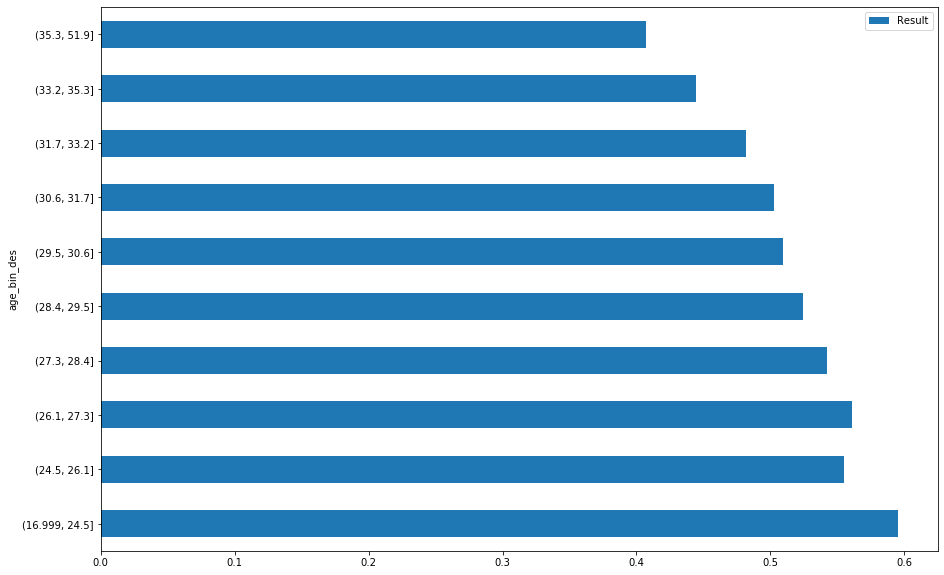

In [1514]:
pd.pivot_table(f,values = 'Result', index = 'age_bin_des', aggfunc = np.mean).plot(kind = 'barh',figsize=(15,10))

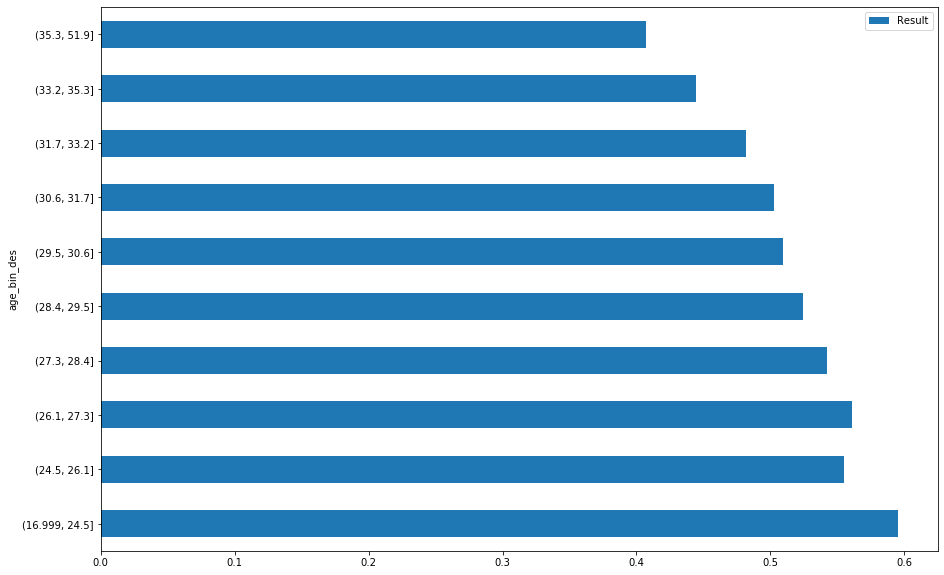

In [1524]:
pd.pivot_table(f,values = ['Result'], index = 'age_bin_des', aggfunc = np.mean).plot(kind = 'barh',figsize=(15,10))

In [1505]:
f[f.age_bins == 13]

,Result,Result_F,Event,Date,Method,Round,Time,Type,T_Format,Ref,Details,Fighter_,KD_,SigStr_e_,SigStr_t_,TotStr_e_,TotStr_t_,TD_e_,TD_t_,SUB_,PASS_,REV_,Head_e_,Head_t_,Body_e_,Body_t_,Leg_e_,Leg_t_,Distance_e_,Distance_t_,Clinch_e_,Clinch_t_,Ground_e_,Ground_t_,First_F,Last_F,Nick_F,Stance_F,W_F,L_F,D_F,DOB_F,FID_F,HT_cm_F,Reach_cm_F,WT_lbs_F,age_F,fight_time,delta_h,delta_w,delta_r,w2d_F,l2d_F,time_avg_F,slpm_avg_F,stracc_avg_F,sapm_avg_F,def_avg_F,td_avg_F,tdacc_avg_F,tddef_avg_F,sub_avg_F,lastfight_F,elo_F,eloprob_F,Head_perT_,Head_acc_,Body_perT_,Body_acc_,Leg_perT_,Leg_acc_,Distance_perT_,Distance_acc_,Clinch_perT_,Clinch_acc_,Ground_perT_,Ground_acc_,PASS_perT_,REV_perT_,KD_perT_,pca_0_F,pca_1_F,pca_2_F,pca_3_F,pca_4_F,age_bins,age_bin_des
MID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f0e299c134cbac37,0.0,NaN,UFC 129: St-Pierre vs Shields,2011-04-30,KO/TKO,2,1:05,LIGHT HEAVYWEIGHT BOUT,3 Rnd (5-5-5),Yves Lavigne,Kick to Head At Distance,Randy Couture,0.0,5.0,23.0,5.0,24.0,0.0,3.0,0.0,0.0,0.0,4.0,21.0,1.0,2.0,0.0,0.0,5.0,21.0,0.0,2.0,0.0,0.0,Randy,Couture,The Natural,Orthodox,19.0,11.0,0.0,1963-06-22,600.0,185.42,190.5,205.0,47.9,6.1,0.00,-20.0,-2.54,19.0,10.0,11.558333,2.784173,0.597222,1.388489,0.584499,2.913669,0.524272,0.59375,0.593525,8.1,84.246646,0.431302,10.701439,0.543379,1.546763,0.86,1.672662,0.920792,3.651079,0.404382,4.226619,0.770492,6.043165,0.687117,2.643885,0.107914,0.053957,10.590311,1.133308,5.546109,2.383511,-1.408408,13,"(47.247, 49.573]"
b28a6efb7197b786,1.0,W,Strikeforce - Diaz vs. Cyborg,2011-01-29,KO/TKO,1,3:13,HEAVYWEIGHT BOUT,3 Rnd (5-5-5),Dan Stell,Punch to Head In Clinch,Herschel Walker,2.0,20.0,26.0,47.0,66.0,1.0,1.0,0.0,0.0,0.0,14.0,20.0,1.0,1.0,5.0,5.0,2.0,5.0,0.0,0.0,18.0,21.0,Herschel,Walker,NaN,Orthodox,2.0,0.0,0.0,1962-03-03,3222.0,185.42,NaN,215.0,48.9,3.2,-2.54,0.0,NaN,1.0,0.0,12.300000,2.538462,0.622642,0.384615,0.500000,1.153846,1.000000,1.00000,0.000000,12.0,10.000000,0.514387,9.230769,0.571429,1.538462,1.00,1.923077,0.714286,2.692308,0.583333,0.384615,1.000000,9.615385,0.625000,8.076923,0.000000,0.000000,9.541925,5.634029,6.810329,-0.077250,2.930063,13,"(47.247, 49.573]"
a49006f9199a015b,1.0,W,Strikeforce - Miami,2010-01-30,KO/TKO,3,2:17,HEAVYWEIGHT BOUT,3 Rnd (5-5-5),Troy Waugh,Punches to Body On Ground,Herschel Walker,0.0,33.0,53.0,112.0,145.0,1.0,1.0,0.0,7.0,0.0,24.0,42.0,4.0,4.0,5.0,7.0,7.0,12.0,1.0,1.0,25.0,40.0,Herschel,Walker,NaN,Orthodox,2.0,0.0,0.0,1962-03-03,3222.0,185.42,NaN,215.0,47.9,12.3,0.00,5.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.365755,-2.252067,4.016959,0.219029,2.188322,13,"(47.247, 49.573]"


##### Save Data

In [1442]:
try: r.drop(['HT_F1','HT_F2','WT_F1','WT_F2','Reach_F1','Reach_F2'],axis=1,inplace=True)
except: pass
r.to_csv(f'D:/jasper/98_general_projects/03_UFC_Predictions/Data/{date}_features.csv')